In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

from fsec.anchoring import BKHK, compute_anchor_neighbors
from fsec.ensemble import generate_base_clusterings, build_bipartite_graph, consensus_clustering
from fsec.plotting import *
from fsec.similarity import compute_sample_anchor_similarities
from fsec.spectral import compute_svd
from fsec.utils import clustering_accuracy

%matplotlib inline
sns.set(style="whitegrid")

In [46]:
from sklearn.datasets import load_digits

# Load dataset
data = load_digits()
X = data.data  # Feature matrix
y = data.target  # Ground truth labels for evaluation

In [47]:
print(data.data.shape)

(1797, 64)


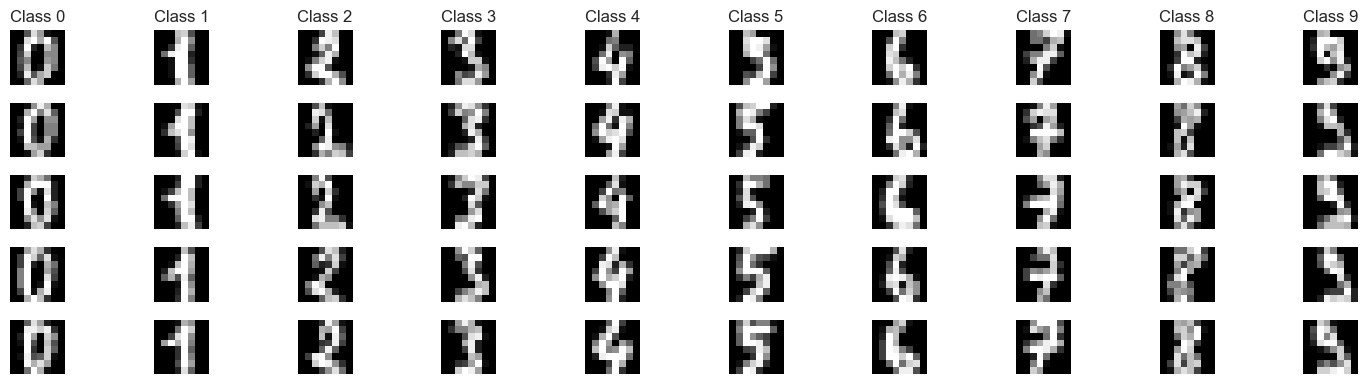

In [48]:
fig, axes = plt.subplots(5, 10, figsize=(15, 4))
classes = np.unique(y)
example_count = 5

for i, cls in enumerate(classes):
    class_indices = np.where(y == cls)[0][:example_count]
    for j, idx in enumerate(class_indices):
        ax = axes[j, i]
        ax.imshow(data.images[idx], cmap='gray')
        ax.axis('off')
        if j == 0:
            ax.set_title(f'Class {cls}')

plt.tight_layout()
plt.show()

## Normalization

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

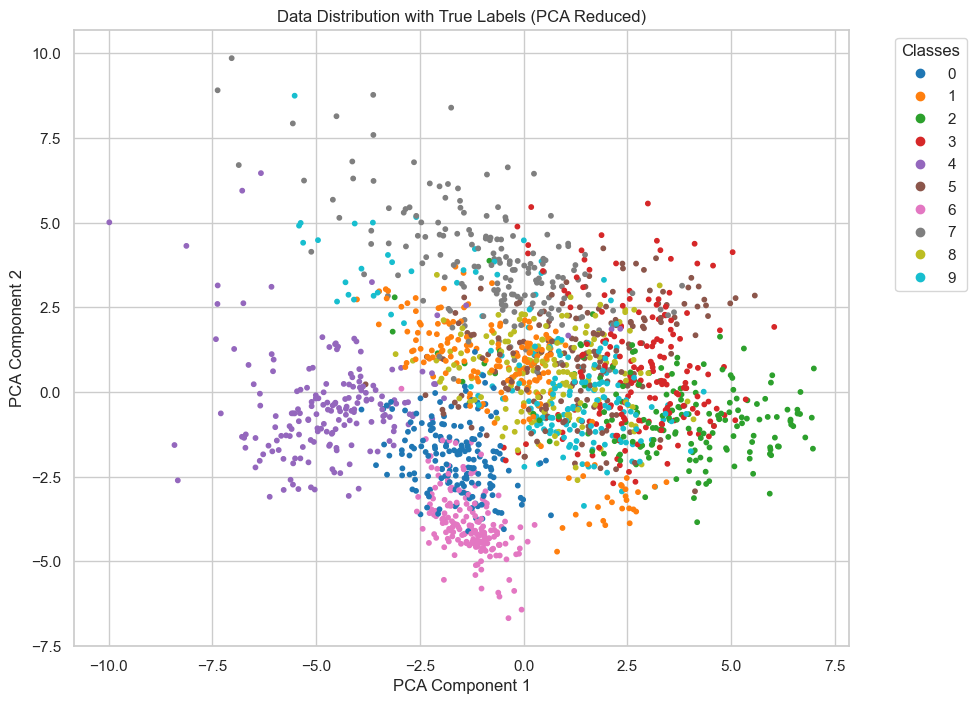

In [50]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Plot the data colored by true labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Data Distribution with True Labels (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [51]:
# Set the desired number of anchors
num_anchors = 45
anchors, anchor_assignments = BKHK(X_scaled, num_anchors)

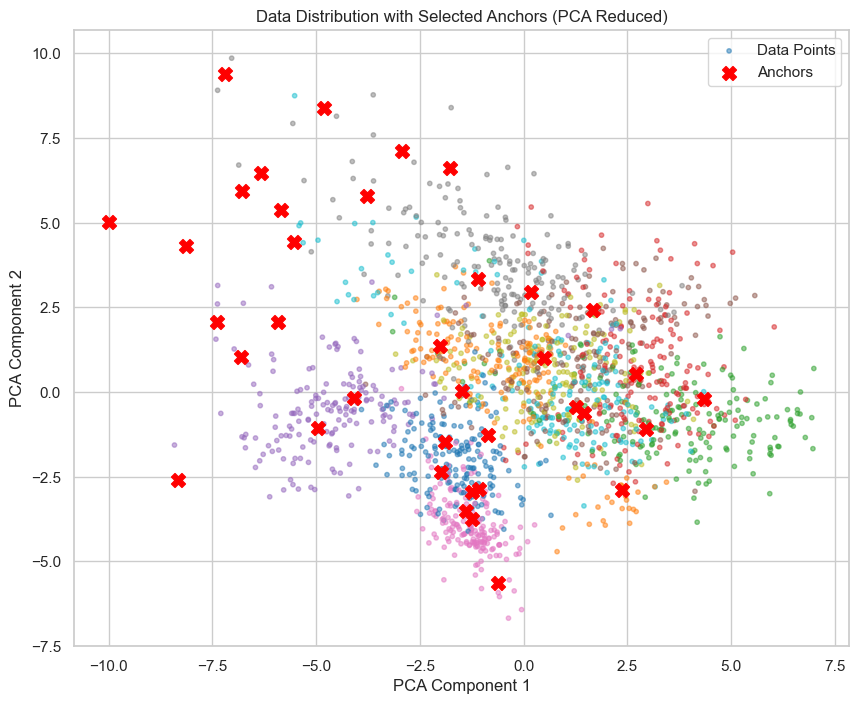

In [52]:
# Plot data points and selected anchors
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', s=10, alpha=0.5, label='Data Points')
anchors_pca = pca.transform(anchors)  # Reduce anchors to 2D
plt.scatter(anchors_pca[:, 0], anchors_pca[:, 1], c='red', marker='X', s=100, label='Anchors')
plt.legend()
plt.title("Data Distribution with Selected Anchors (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [53]:
# Set K' (should be greater than K)
K_prime = 13
anchor_neighbors = compute_anchor_neighbors(anchors, K_prime)

In [54]:
# Set K (number of nearest anchors to consider)
K = 2
W = compute_sample_anchor_similarities(X_scaled, anchors, anchor_assignments, anchor_neighbors, K)

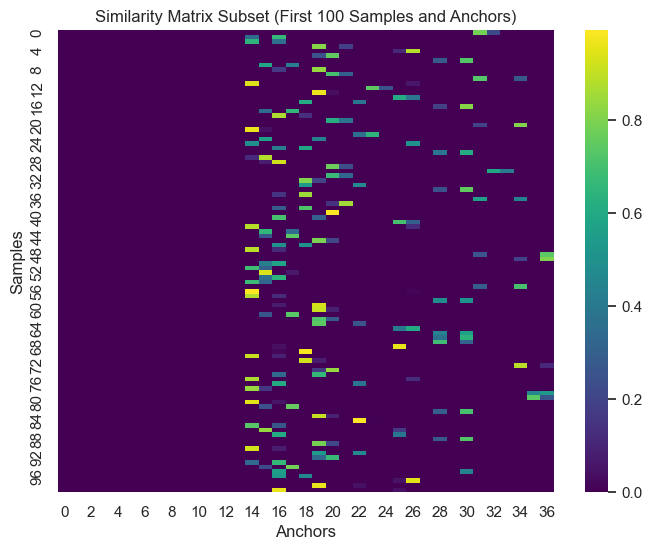

In [55]:
# Convert W to dense for visualization (use a subset for large matrices)
subset = 100  # Number of samples and anchors to visualize
W_dense = W[:subset, :subset].toarray()

plt.figure(figsize=(8, 6))
sns.heatmap(W_dense, cmap='viridis')
plt.title("Similarity Matrix Subset (First 100 Samples and Anchors)")
plt.xlabel("Anchors")
plt.ylabel("Samples")
plt.show()

In [56]:
# Set the number of components (should be greater than the max number of clusters)
n_components = 20
U = compute_svd(W, n_components)

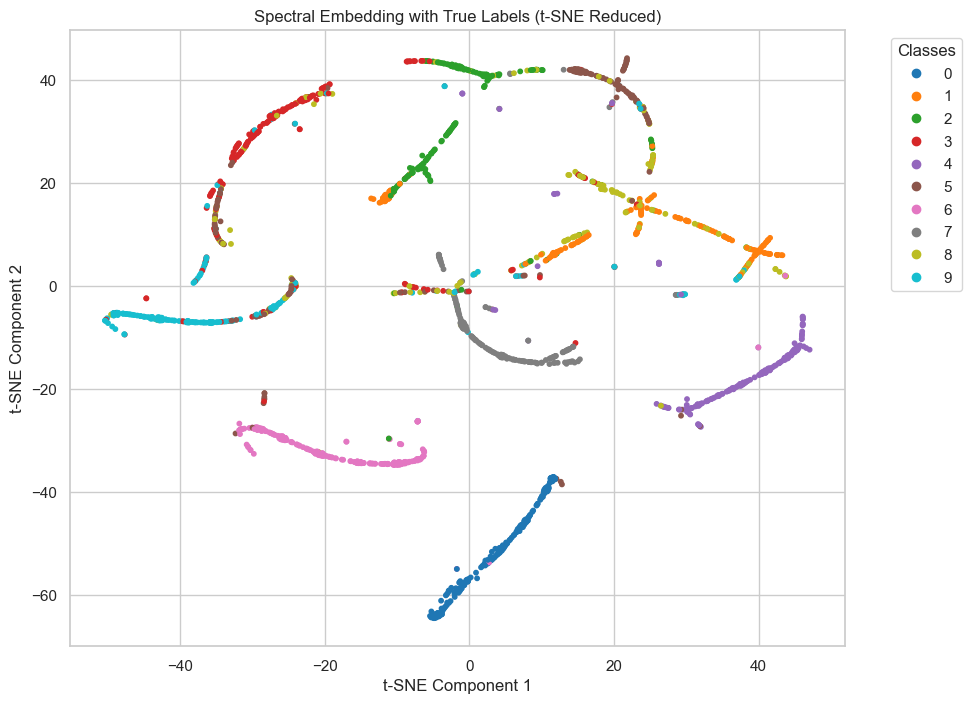

In [57]:
# Reduce spectral embeddings to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
U_tsne = tsne.fit_transform(U)

# Plot the spectral embeddings colored by true labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(U_tsne[:, 0], U_tsne[:, 1], c=y, cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Spectral Embedding with True Labels (t-SNE Reduced)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [58]:
# Define a list of different cluster numbers
num_clusters_list = [8, 9, 10, 11, 12]
base_clusterings = generate_base_clusterings(U, num_clusters_list)

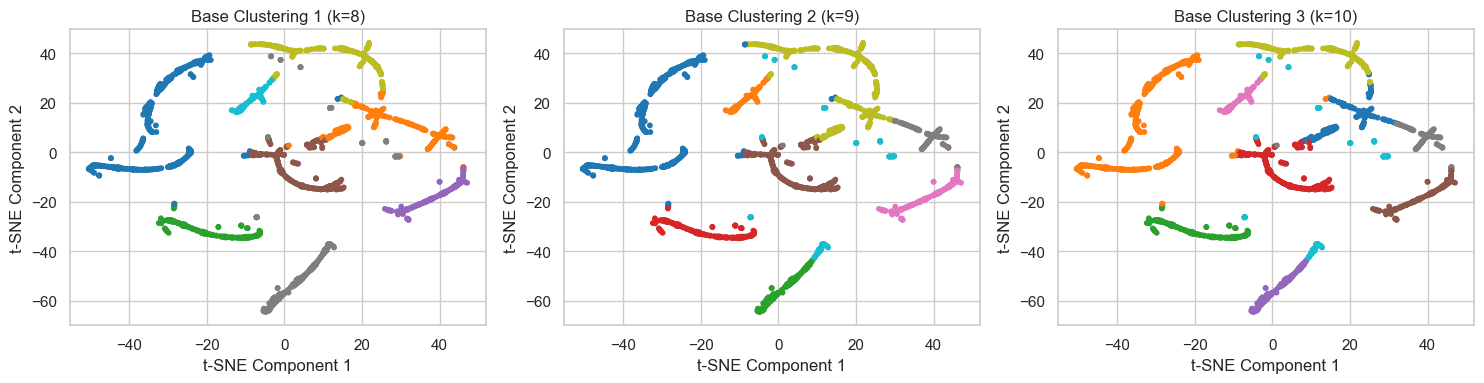

In [59]:
# Visualize first 3 base clusterings
num_visualize = 3
plt.figure(figsize=(15, 4))
for i in range(num_visualize):
    plt.subplot(1, num_visualize, i+1)
    labels = base_clusterings[i]
    plt.scatter(U_tsne[:, 0], U_tsne[:, 1], c=labels, cmap='tab10', s=10)
    plt.title(f"Base Clustering {i+1} (k={num_clusters_list[i]})")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()

In [60]:
H = build_bipartite_graph(base_clusterings)

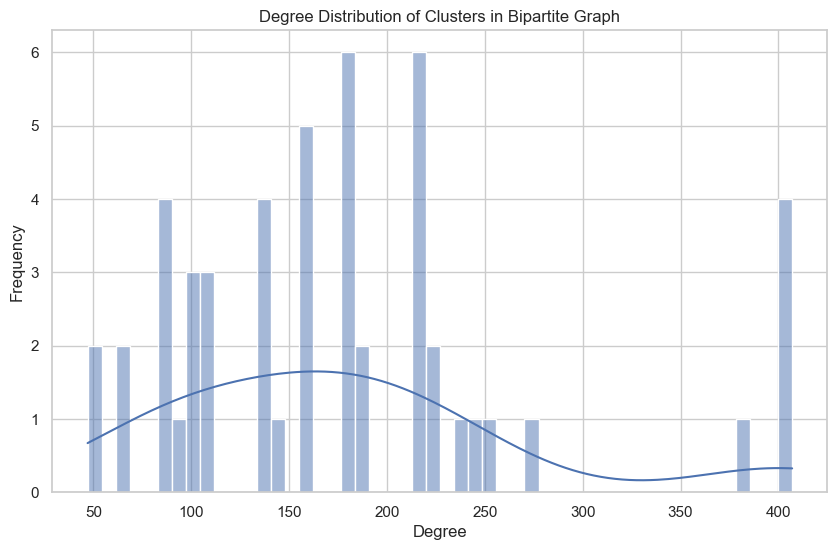

In [61]:
# Compute degree of each cluster
cluster_degrees = np.array(H.sum(axis=0)).flatten()

plt.figure(figsize=(10, 6))
sns.histplot(cluster_degrees, bins=50, kde=True)
plt.title("Degree Distribution of Clusters in Bipartite Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [62]:
# Set the desired number of clusters in the final result
final_n_clusters = 10
final_labels = consensus_clustering(H, final_n_clusters)

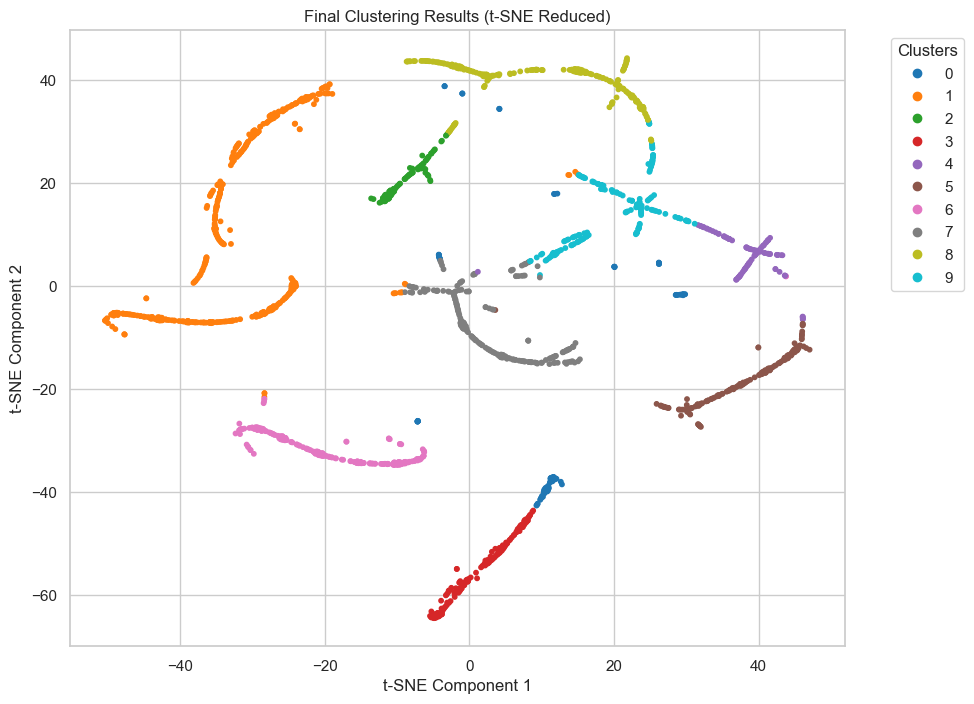

In [63]:
# Reduce the final clustering labels for visualization using PCA
# Already have U_tsne from earlier

# Plot the final clustering
plt.figure(figsize=(10, 8))
scatter = plt.scatter(U_tsne[:, 0], U_tsne[:, 1], c=final_labels, cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Final Clustering Results (t-SNE Reduced)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [64]:
# Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(y, final_labels)
# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(y, final_labels)
# Clustering Accuracy (Optional, requires Hungarian Algorithm)
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment

acc = clustering_accuracy(y, final_labels)

print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Clustering Accuracy (ACC): {acc:.4f}")

Normalized Mutual Information (NMI): 0.6022
Adjusted Rand Index (ARI): 0.4477
Clustering Accuracy (ACC): 0.5838


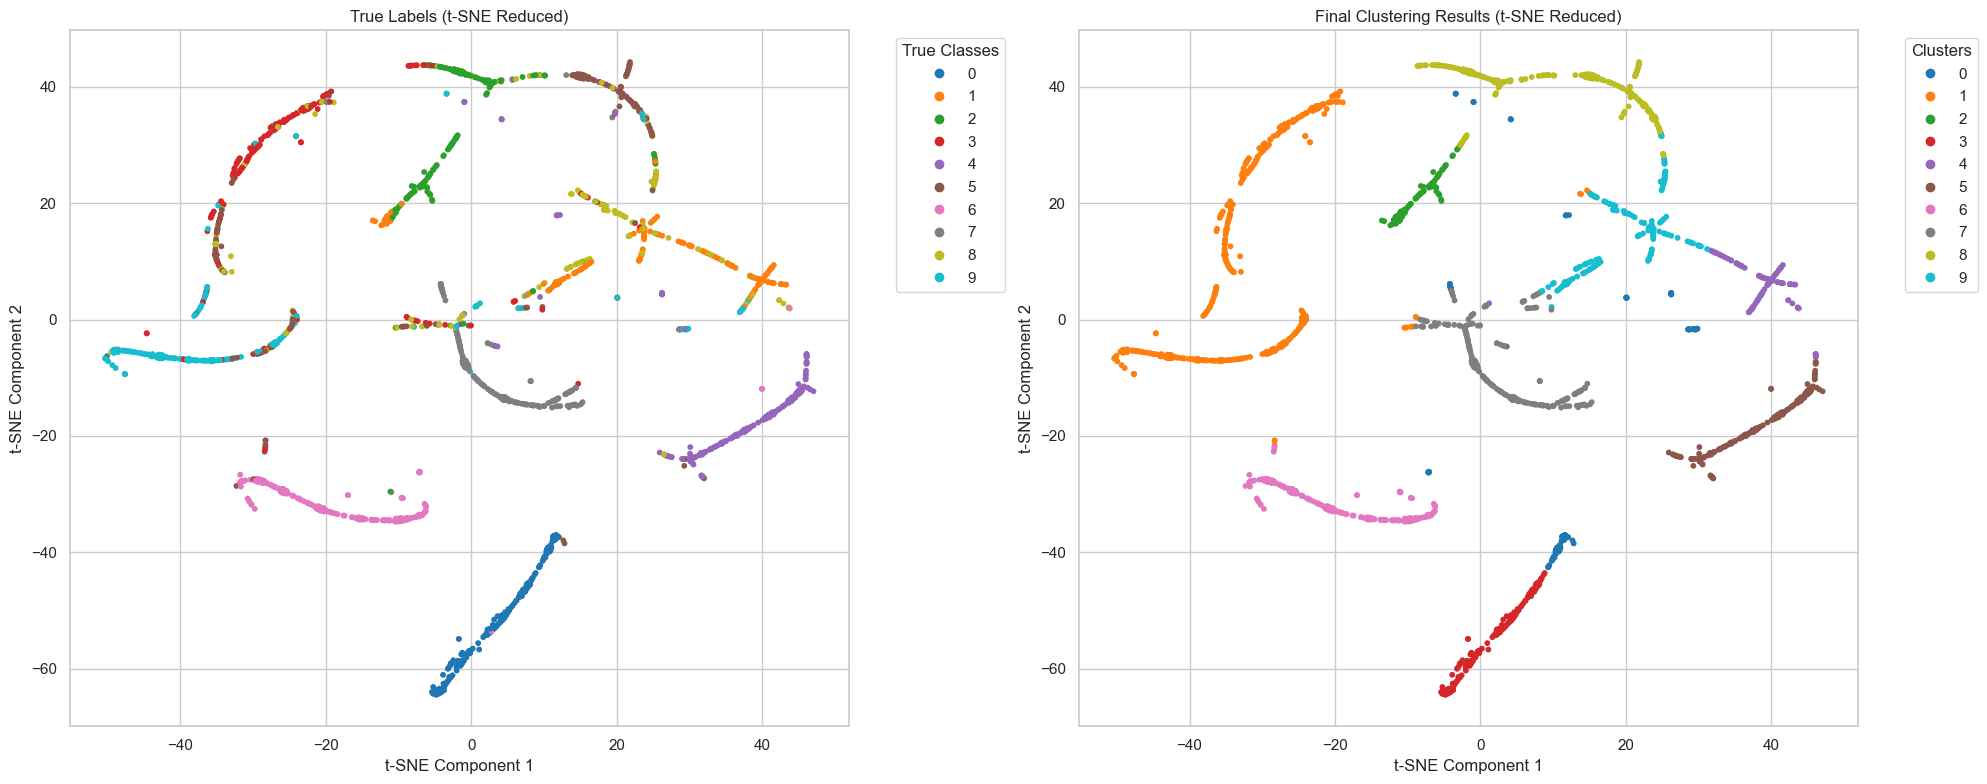

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# True Labels
scatter = axes[0].scatter(U_tsne[:, 0], U_tsne[:, 1], c=y, cmap='tab10', s=10)
axes[0].legend(*scatter.legend_elements(), title="True Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].set_title("True Labels (t-SNE Reduced)")
axes[0].set_xlabel("t-SNE Component 1")
axes[0].set_ylabel("t-SNE Component 2")

# Final Clusters
scatter = axes[1].scatter(U_tsne[:, 0], U_tsne[:, 1], c=final_labels, cmap='tab10', s=10)
axes[1].legend(*scatter.legend_elements(), title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].set_title("Final Clustering Results (t-SNE Reduced)")
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")

plt.tight_layout()
plt.show()

## Optimizations

### Bayesian Optimization

In [66]:
import optuna

def objective(trial):
    num_anchors = trial.suggest_int('num_anchors', 25, 100)
    K_prime = trial.suggest_int('K_prime', 2, 15)
    K = trial.suggest_int('K', 1, 15)
    # n_components = trial.suggest_int('n_components', 20, 40)
    n_components = 10
    
    if num_anchors < n_components:
        return 0.0
    
    if K_prime <= K:
        return 0.0
    
    anchors, anchor_assignments = BKHK(X_scaled, num_anchors)
    anchor_neighbors = compute_anchor_neighbors(anchors, K_prime)
    W = compute_sample_anchor_similarities(X_scaled, anchors, anchor_assignments, anchor_neighbors, K)
    U = compute_svd(W, n_components)
    base_clusterings = generate_base_clusterings(U, [8, 9, 10, 11, 12])
    H = build_bipartite_graph(base_clusterings)
    final_labels = consensus_clustering(H, n_clusters=10)
    
    nmi = normalized_mutual_info_score(y, final_labels)
    return nmi

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)

print(f"Best NMI: {study.best_value}")
print(f"Best Parameters: {study.best_params}")

[I 2024-11-30 02:13:28,517] A new study created in memory with name: no-name-aa3e2bab-f5ec-4789-a9d1-f4012829da84
[I 2024-11-30 02:13:28,766] Trial 0 finished with value: 0.4181854518545967 and parameters: {'num_anchors': 97, 'K_prime': 14, 'K': 1}. Best is trial 0 with value: 0.4181854518545967.
[I 2024-11-30 02:13:28,975] Trial 1 finished with value: 0.6043692844013163 and parameters: {'num_anchors': 37, 'K_prime': 14, 'K': 2}. Best is trial 1 with value: 0.6043692844013163.
[I 2024-11-30 02:13:28,976] Trial 2 finished with value: 0.0 and parameters: {'num_anchors': 56, 'K_prime': 4, 'K': 10}. Best is trial 1 with value: 0.6043692844013163.
[I 2024-11-30 02:13:28,977] Trial 3 finished with value: 0.0 and parameters: {'num_anchors': 28, 'K_prime': 3, 'K': 10}. Best is trial 1 with value: 0.6043692844013163.
[I 2024-11-30 02:13:28,978] Trial 4 finished with value: 0.0 and parameters: {'num_anchors': 40, 'K_prime': 12, 'K': 12}. Best is trial 1 with value: 0.6043692844013163.
[I 2024-11

Best NMI: 0.664677834839725
Best Parameters: {'num_anchors': 51, 'K_prime': 4, 'K': 2}
